<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/simulation_on_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##IDP simulation on AFM stage with OpenMM

This notebook consists of the following steps:
1. Run molecular dynamics simulation of a protein on the AFM state (interaction between protein and stage is a very naive vdW)
2. Load the simulated trajectory into a MDtraj trajectory object
3. Emulate AFM images by using morphology operations implemented in ColabBTR
4. Download a picked MDtrajctory object file (HDF h5 file) and corresponding pseudo AFM images (numpy npy file)

In [1]:
#@title Install Conda
#@markdown It will restart the kernel (session), don't worry.
#!pip install -q condacolab
#import condacolab
#condacolab.install_miniconda()
#condacolab.install_miniforge()

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [2]:
#@title Install dependencies
%%time
import os

print("upgrading gdown...")
os.system("pip install -q --upgrade --no-warn-conflicts gdown")

print("installing colabbtr...")
os.system("pip install git+https://github.com/matsunagalab/ColabBTR")

print("installing py3Dmol...")
os.system("pip install py3Dmol")
#os.system("pip install mdtraj")

print("installing openmm and mdtraj")
os.system(f"mamba install -y -c conda-forge openmm=8.1.1 mdtraj=1.9.9 2>&1 1>/dev/null")

upgrading gdown...
installing colabbtr...
installing py3Dmol...
installing openmm and mdtraj
CPU times: user 709 ms, sys: 83.6 ms, total: 792 ms
Wall time: 2min 54s


0

In [3]:
#@title Prepare simulation system
import openmm as mm
from openmm import *
from openmm.app import *
import openmm.unit as unit
from sys import stdout
import numpy as np
import math

!gdown 1hsuYBPlmUPLb-5GHSilZykn9Vu8CQODz

polymer_file = "1_cg.pdb"
output_file = "polymer_input.pdb"

# load pdb
pdb = PDBFile(polymer_file)
positions = pdb.positions

# rotate around x-axis by 90 degrees with rotation matrix
theta = -math.pi/4
rotation_matrix = np.array([[1, 0, 0], [0, math.cos(theta), -math.sin(theta)], [0, math.sin(theta), math.cos(theta)]])
new_positions = [np.dot(pos.value_in_unit(unit.nanometer), rotation_matrix) for pos in positions]
# rotate y-axis by 90 degrees around with rotation matrix
theta = -math.pi/8
rotation_matrix = np.array([[math.cos(theta), 0, math.sin(theta)], [0, 1, 0], [-math.sin(theta), 0, math.cos(theta)]])
new_positions = [np.dot(pos, rotation_matrix) for pos in new_positions]
new_positions = [(pos + np.array([-10,-10,3.6])) for pos in new_positions]
new_positions = new_positions*unit.nanometer
pdb.positions = new_positions

# add bond
cgElement = element.Element.getBySymbol('C')
length = pdb.topology.getNumAtoms()
atom_list = list(pdb.topology.atoms())
bond_list = []
for i in range(length):
    atom_list[i].name = 'CG'
    atom_list[i].element = cgElement
    if i < length-1:
        _bond = pdb.topology.addBond(atom_list[i], atom_list[(i+1)])
        bond_list.append(_bond)

topology = pdb.topology
positions = pdb.positions

# create the system and add the particles to it
system = System()
for atom in topology.atoms():
    #print(vars(atom))
    system.addParticle(atom.element.mass)

# harmonic bond force
harmonic_bond_force = HarmonicBondForce()
for bond in topology.bonds():
    harmonic_bond_force.addBond(bond.atom1.index, bond.atom2.index, 0.38, 1000)

# Lennard-Jones potential
expression = '4*epsilon*((sigma/r)^12-(sigma/r)^6);'\
            + ' sigma=0.5*(sigma1+sigma2);'\
            + ' epsilon=sqrt(epsilon1*epsilon2)'
custom_nb_force = CustomNonbondedForce(expression)
custom_nb_force.addPerParticleParameter('sigma')
custom_nb_force.addPerParticleParameter('epsilon')
# Add the parameters for each particle
for atom in topology.atoms():
    custom_nb_force.addParticle([0.5, 1.0])
# Create exclusions for directly bonded atoms
bond_exclusions = [(bond[0].index, bond[1].index) for bond in topology.bonds()]
print('bond_exclusions: ', len(bond_exclusions))
custom_nb_force.createExclusionsFromBonds(bond_exclusions, 1)
# Set a cutoff of 1.5nm
custom_nb_force.setNonbondedMethod(CustomNonbondedForce.CutoffNonPeriodic)
print('PBC:', custom_nb_force.usesPeriodicBoundaryConditions())
custom_nb_force.setCutoffDistance(1.5*unit.nanometers)

# Go-like potential
# Go_expression = 'epsilon*(5*(r0/r)^12-6*(r0/r)^10);'
Go_expression = 'epsilon*(r-r0)^2;'
custom_go_force = CustomBondForce(Go_expression)
custom_go_force.addPerBondParameter('r0')
custom_go_force.addPerBondParameter('epsilon')
# Add the parameters for each particle
go_bonds = []
for i in range(267-1):
    for j in range(i+1, 267):
        if i != j:
            # iとjが8Å以内にある場合
            # print(list(positions[i]))
            # calculate distance
            _dist = np.linalg.norm(np.array(positions[i])-np.array(positions[j]))
            # print(type(_dist))
            if _dist * unit.nanometers < 0.8 * unit.nanometers:
                # print(i, j, _dist)
                _bond = custom_go_force.addBond(i, j, [_dist * unit.nanometers, 100])
                go_bonds.append(_bond)
print('go_bonds: ', len(go_bonds))

# z=0の平面に対するLJポテンシャル
stage_eps = 100.0
expression = '4*epsilon*((sigma/z)^12-(sigma/z)^10);'
# expression = 'k*(z-z0)^2;'
stage_force = CustomExternalForce(expression)
# stage_force.addGlobalParameter('k', 1000)
# stage_force.addGlobalParameter('z0', 0.0)
stage_force.addPerParticleParameter('sigma')
stage_force.addPerParticleParameter('epsilon')
# Add the parameters for each particle
stage_force_index = []
for atom in topology.atoms():
    # _idx = stage_force.addParticle(atom.index, [])
    _idx = stage_force.addParticle(atom.index, [0.38, stage_eps])
    stage_force_index.append(_idx)
print('stage_force_index: ', len(stage_force_index))

cm_motion_remover = CMMotionRemover()

# Add the forces to the system
system.addForce(harmonic_bond_force)
system.addForce(custom_nb_force)
system.addForce(custom_go_force)
system.addForce(stage_force)
# system.addForce(cm_motion_remover)

with open('system.xml', 'w') as output:
    output.write(XmlSerializer.serialize(system))

Downloading...
From: https://drive.google.com/uc?id=1hsuYBPlmUPLb-5GHSilZykn9Vu8CQODz
To: /content/1_cg.pdb
100% 61.0k/61.0k [00:00<00:00, 83.2MB/s]
bond_exclusions:  743
PBC: False
go_bonds:  1147
stage_force_index:  744


In [6]:
#@title Run simulation
#@markdown total simulation steps of simulation
nsteps = 50000#@param {type:"raw"}
#@markdown trajectory saved at `every frequency` steps.
save_frequency = 1000#@param {type:"raw"}
#@markdown

integrator = LangevinMiddleIntegrator(300*unit.kelvin, 0.01/unit.picosecond, 0.010*unit.picoseconds)
integrator.setRandomNumberSeed(321)
simulation = Simulation(topology, system, integrator)

simulation.context.setPositions(positions)
simulation.context.applyConstraints(1e-2)
simulation.minimizeEnergy()
simulation.step(50000)

# simulation.reporters.append(PDBReporter('output_2.pdb', save_frequency))
simulation.reporters.append(DCDReporter('run.dcd', save_frequency))
simulation.reporters.append(StateDataReporter(stdout, save_frequency,
  totalSteps=50000+nsteps, step=True, speed=True, progress=True, potentialEnergy=True, temperature=True, separator='\t'))

simulation.step(nsteps)

# save the final configuration
with open('run.pdb','w') as f:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(), f)

# save the final state
simulation.saveState('run.xml')

#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"
51.0%	51000	-14425.403393149376	326.13316463800555	0
52.0%	52000	-14515.077736616135	329.9938581664131	2.42e+04
53.0%	53000	-14500.652539372444	325.73918949929265	2.53e+04
54.0%	54000	-14540.916267871857	323.3443714509204	2.54e+04
55.0%	55000	-14487.528147101402	314.8367403720431	2.55e+04
56.0%	56000	-14608.554151535034	319.5781364440294	2.56e+04
57.0%	57000	-14552.964175641537	317.9432084760115	2.57e+04
58.0%	58000	-14534.247732043266	318.26248192488833	2.58e+04
59.0%	59000	-14528.590199887753	311.9042485303104	2.59e+04
60.0%	60000	-14609.966106235981	320.56832525587635	2.59e+04
61.0%	61000	-14594.923839092255	315.91588593172173	2.57e+04
62.0%	62000	-14587.102900743484	312.8750718143125	2.58e+04
63.0%	63000	-14605.815451920033	319.4316725654593	2.58e+04
64.0%	64000	-14453.548498511314	303.7906695301911	2.58e+04
65.0%	65000	-14494.260317444801	303.2435035555643	2.58e+04
66.0%	66000	-14425.18986666202

In [7]:
#@title Load and visualize the trajectory
import mdtraj as md
import py3Dmol
import warnings
warnings.filterwarnings('ignore')

#@markdown Visualize the trajectory? Is is computationally touch, so the frames should be less than < 100 frames
#@markdown If false, just load the trajectory withoug visualizig it.
is_visualize = True #@param {type:"boolean"}
stride = 1

traj = md.load('run.dcd', top='run.pdb')
traj = traj[::stride]

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if is_visualize:
    # Write out frames for animation
    for i in range(0, traj.n_frames, stride):
        md.Trajectory(traj.xyz[i:i+1], traj.topology).save_pdb('' + str(i) + '.pdb')

    # Load frames as molecules
    molecules = []
    for i in range(0, traj.n_frames, stride):
        with open('' + str(i) + '.pdb') as ifile:
            molecules.append(Molecule(ifile))

    models = ""
    for i in range(len(molecules)):
        models += "MODEL " + str(i) + "\n"
    for j,mol in enumerate(molecules[i]):
        models += str(mol)
    models += "ENDMDL\n"
    #view.addModelsAsFrames(models)

    # Animation
    view = py3Dmol.view(width=800, height=600)
    view.addModelsAsFrames(models)
    for i, at in enumerate(molecules[0]):
        default = {"sphere": {'color': 'spectrum'}}
        view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

    view.zoomTo()
    view.animate({'loop': "forward"})
    view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
#@title Emulate AFM images from the trajectory
#@markdown It takes a long time. please wait a while...
import torch
import gdown
import mdtraj as md
from tqdm.notebook import tqdm
from colabbtr.morphology import Atom2Radius
from colabbtr.morphology import surfing
from colabbtr.morphology import idilation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prepare the radii of atoms as 1D tensor
radii = []
for residue in traj.topology.residues:
    residue_name = residue.name
    if residue_name in Atom2Radius:
        radii.append(Atom2Radius[residue_name])
    else:
        print(f"Warning: Radius not found for residue {residue_name}")
        radii.append(None)

radii = torch.tensor(radii, dtype=torch.float32, device=device)

# prepare the XYZ coordinates of atoms as 3D tensor (nframe x natom x 3)
xyz = traj.xyz
xyz = torch.tensor(xyz, dtype=torch.float32, device=device)

# prepare tip shpae as 2D tensor
gdown.download('https://drive.google.com/uc?id=1hdAVE5ZljRsLgX2QGt6hytLemChDMxg9', 'tip.npy', quiet=False)
tip = np.load("tip.npy")
tip = torch.tensor(tip, dtype=torch.float32, device=device)

# prepare AFM stage settings
# specify range and resolution in nm
config = {"min_x":-50.0, "max_x":50.0,
          "min_y":-50.0, "max_y":50.0,
          "resolution_x":2.0,
          "resolution_y":2.0}

# Assuming: xyz is a tensor of shape (nframe, num_atoms, 3)
# nframe is the number of frames, num_atoms is the number of atoms in each frame

# Generate the image for the first frame and get its shape
surface = surfing(xyz[0, :, :], radii, config)
image = idilation(surface, tip)
image_shape = image.shape

# Initialize a 3D tensor to store all images
images = torch.zeros((traj.n_frames, *image_shape), dtype=torch.float32, device=device)

# Store the first image in the 3D tensor
images[0] = image

# Generate and store images for each remaining frame in the 3D tensor
for iframe in tqdm(range(1, traj.n_frames)):
    #print(iframe)
    xyz_iframe = xyz[iframe, :, :]
    xyz_iframe -= xyz_iframe.mean(dim=0)
    xyz_iframe[:, 2] -= xyz_iframe[:, 2].min()
    surface = surfing(xyz_iframe, radii, config)
    image = idilation(surface, tip)
    images[iframe] = image

Downloading...
From: https://drive.google.com/uc?id=1hdAVE5ZljRsLgX2QGt6hytLemChDMxg9
To: /content/tip.npy
100%|██████████| 880/880 [00:00<00:00, 1.25MB/s]


  0%|          | 0/49 [00:00<?, ?it/s]

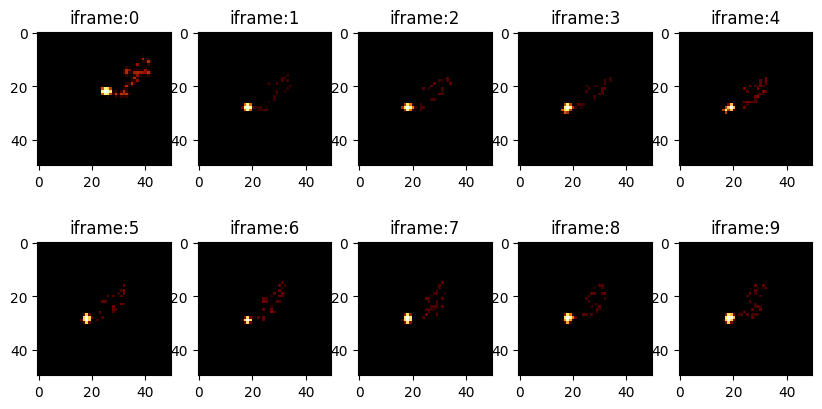

In [9]:
#@title Visualize the emulated images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].cpu().numpy(), interpolation='none', origin='upper',
           cmap="afmhot", aspect="equal")
    ax.set_title(f"iframe:{i}")

#plt.xlabel(r"x")
#plt.ylabel(r"y" )
#plt.colorbar()
plt.show()

In [10]:
#@title Save and download files (traj.h5 and images.npy)
import numpy as np
from google.colab import files

traj.save('traj.h5')
files.download('traj.h5')

# later you can load the file with:
# import mdtraj as md
# traj = md.load('traj.h5')

np.save('images.npy', images.cpu().numpy())
files.download('images.npy')

# later you can load the file with:
# images = np.load('images.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>